# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutoria](https://waterprogramming.wordpress.com/2017/11/19/open-exploration-with-the-exploratory-modelling-workbench/) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply scenario discovery

1. Generate 10 policies and 1000 scenarios and evaluate them.
2. The experiments array contains the values for each of the 100 decision levers. This might easily mess up the analysis. Remove these columns from the experiment array. *hint: you can use either pandas (convert experiments to dataframe, drop columsn, convert back to recarray) or numpy.lib.recfunctions for dropping columns from the experiments recarray*
3. Apply scenario discovery, focussing on the 10 percent of worst outcomes for reliability


In [1]:
import math
import ast

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lake import *

from ema_workbench import (perform_experiments, Model, ReplicatorModel, RealParameter, ScalarOutcome,
                           Constant, ema_logging, MultiprocessingEvaluator)

ema_logging.log_to_stderr(ema_logging.INFO)

C:\Anaconda3\envs\py36_32\lib\site-packages\ema_workbench\em_framework\optimization.py:29: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


<Logger EMA (DEBUG)>

In [2]:
model = Model('lakeproblem', function=lake_problem)
model.time_horizon = 100

#specify uncertainties
model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2.0, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]
 
# set levers
model.levers = [RealParameter(str(i), 0, 0.1) for i in range(model.time_horizon)]
  
#specify outcomes
model.outcomes = [ScalarOutcome('max_P'),
                  ScalarOutcome('utility'),
                  ScalarOutcome('inertia'),
                  ScalarOutcome('reliability')]
 
# override some of the defaults of the model
model.constants = [Constant('alpha', 0.41),
                   Constant('steps', 100)]

### MultiProcessor

In [3]:
n_scenarios=1000
n_policies=10

with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=n_scenarios, policies=n_policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [4]:
def make_df(results):
    experiments, outcomes = results

    # DATA of INPUTS
    experiments = np.lib.recfunctions.drop_fields(base = experiments, drop_names = [str(i) for i in range(100)])
    experiments = pd.DataFrame(experiments)

    n_scenarios = experiments["scenario_id"].nunique()
    n_policies = experiments["policy"].nunique()
    
    # POLICIES (STRING representation into DICTIONARY)
    policies = experiments["policy"].unique()
    func = lambda x: ast.literal_eval(x)
    vfunc = np.vectorize(func)
    policies = vfunc(policies)
    policies = pd.DataFrame(policies)

    experiments["policy"] = np.repeat(range(n_policies), n_scenarios)

    # DATA of OUTPUTS
    outcomes = pd.DataFrame(outcomes)
    outcomes["scenario_id"] = experiments["scenario_id"].values
    outcomes["policy"] = experiments["policy"].values
    
    return experiments, outcomes, policies

In [5]:
experiments, outcomes, policies = make_df(results)
experiments.head()

,b,delta,mean,q,stdev,scenario_id,policy,model
0,0.243178,0.932722,0.037175,4.218586,0.001972,0,0,lakeproblem
1,0.125643,0.945365,0.046855,3.823718,0.004007,1,0,lakeproblem
2,0.334583,0.969186,0.029852,2.625683,0.004537,2,0,lakeproblem
3,0.333426,0.935547,0.013977,4.145966,0.003587,3,0,lakeproblem
4,0.361015,0.947643,0.029074,4.060265,0.003481,4,0,lakeproblem


In [6]:
outcomes.head()

,inertia,max_P,reliability,utility,scenario_id,policy
0,0.363636,4.549746,0.2609,0.258859,0,0
1,0.363636,8.854153,0.0805,0.326297,1,0
2,0.363636,3.157438,0.1985,0.585021,2,0
3,0.363636,0.274168,1.0000,0.271666,3,0
4,0.363636,0.304742,1.0000,0.341793,4,0


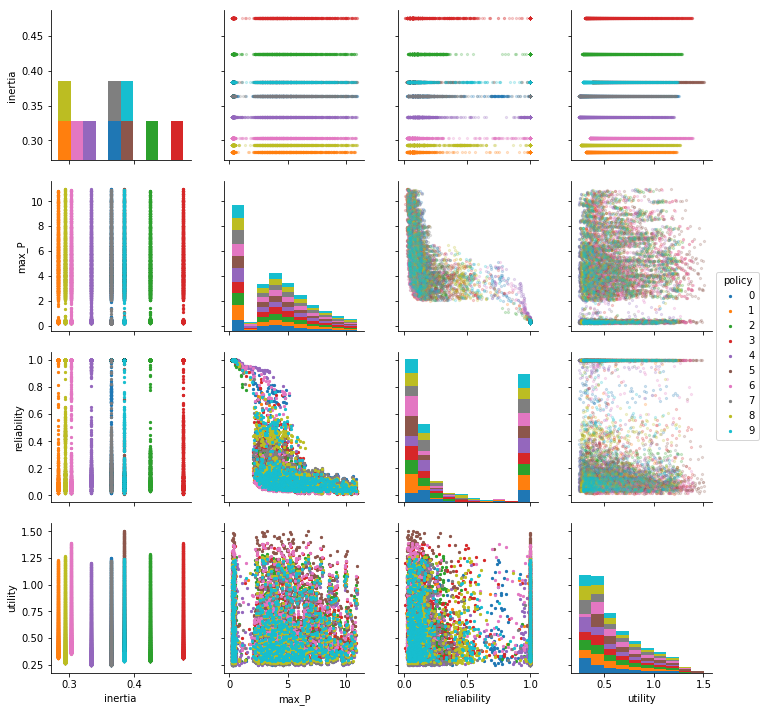

In [7]:
g = sns.PairGrid(outcomes, vars = outcomes.columns[:4],
                 hue = "policy",
                )
g.map_diag(plt.hist)
g.map_upper(plt.scatter, s = 5, alpha = 0.2)
g.map_lower(plt.scatter, s = 5, alpha = 1.0)
g.add_legend()

## Visualize the results using Dimensional Stacking
Take the classification of outcomes as used in step 3 of scenario discovery, and instead visualize the results using dimensional stacking. How do these results compare to the insights from scenario discovery?

## Apply sensitivity analysis
There is substantial support in the ema_workbench for global sensitivity. For this, the workbench relies on [SALib](https://salib.readthedocs.io/en/latest/) and feature scoring which is a machine learning alternative for global sensitivity analysis. Generate 10 random release policies. Generate 1000 experiments, and analyse the results using extra trees feature scoring for all outcomes of interest. What can you conclude from these results?

*hint: you can use [seaborn heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for a nice figure of the results*